# Save Wally!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import savewally
from importlib import reload
from PIL import Image
from skimage import feature

In [2]:
df = pd.read_csv("data/Linga Holm_ORKlh_2016_3&4_20180906.csv")
df = df[df.image_file =='StitchMICE_ORKlh16_3_1104_CP_FINAL.tif']

## Append filepaths to dataframe

In [3]:
# loop over every row
k = 8  # level
filepaths = []
for i, row in df.iterrows():
    row, col = savewally.LocateTile(row.x, row.y, savewally.SizeTile)
    filepaths.append(savewally.GetFilepath(k, row, col))
df["fp"] = filepaths

In [4]:
df["class"].unique()

array(['whitecoat', 'moulted', 'dead', 'double'], dtype=object)

## Load images

In [5]:
images = []
image_filepaths = []
for fp in df.fp.unique():  # [df["class"]=="whitecoat"]
    im = Image.open("data/Stitch_3/" + fp)
    images.append(im)
    image_filepaths.append(fp)

In [6]:
def plot_rect(img, x, y, dx, dy):
    patch, bbox = extract_patch(img, x, y, dx, dy)
    extent = bbox[0], bbox[2], bbox[1], bbox[3]
    # plot tile
    plt.imshow(np.asarray(img)[::-1,:,:])
    # plot seal loc
    plt.scatter(x, y)
    # plot patch
    plt.imshow(patch[::-1,:,:], extent=extent,  alpha=1)
    plt.imshow(np.ones(patch[::-1,:,:].shape), extent=extent,  alpha=0.3)
    plt.xlim(0,256)
    plt.ylim(0,256)

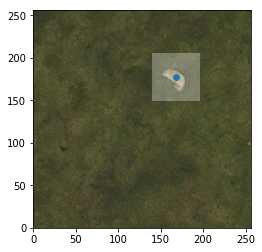

In [165]:
x, y = df[df.fp == image_filepaths[39]].x.values[0], df[df.fp == image_filepaths[39]].y.values[0]
plot_rect(images[39], x%256, y%256, 28, 28)

# Generate patches

In [7]:
def do_box(x, y, dx, dy):
    return  x - dx, y - dy, x + dx, y + dy 

def overlap(b1,b2):
    hoverlaps = (b1[0] <= b2[2]) and (b1[2] >= b2[0])
    voverlaps = (b1[3] >= b2[1]) and (b1[1] <= b2[3])
    return hoverlaps and voverlaps

def extract_patch(img, x, y, dx, dy):
    """
    x,y need to be in image coordinates!
    """
    box = do_box(x, y, dx, dy)  # bounding box
    patch = np.asarray(img)[::-1,:,:][box[1]:box[3], box[0]:box[2]]  # extract patch from image array
    return patch, box

In [8]:
dx, dy = 32, 32

In [9]:
import tqdm

In [40]:
def extract_random_patches(img, fp, n_patches, plot=False):
    patches = []
    patches_boxes = []
    patches_bool = []
    patches_fp = []

    for n in range(n_patches):
        # generate a random point
        x,y = (np.random.randint(dx, 256 - dx), 
               np.random.randint(dy, 256 - dy))
        # extract a patch, and the patch box
        patch, patch_box = extract_patch(img, x, y, dx, dy)
              
        if plot:
            plot_rect(img, x, y, dx, dy)
        
        # store
        patches.append(patch)  # image patches
        patches_boxes.append(patch_box)  # patch bounding box
        patches_fp.append(fp)  # filepath
        
        # check if it overlaps with a seal
        seals = df[df.fp==fp]  # grab all the seal coordinates of the tile
        for i, seal in seals.iterrows():
            # there is at least 1 seal in the image
            # create a seal box
            seal_box = do_box(seal.x%256, seal.y%256, dx, dy)
            # check if the two boxes overlap
            is_seal = overlap(seal_box, patch_box)
            if plot:
                print(is_seal)
        patches_bool.append(is_seal)  # store bool
            
    return patches, patches_boxes, patches_bool, patches_fp

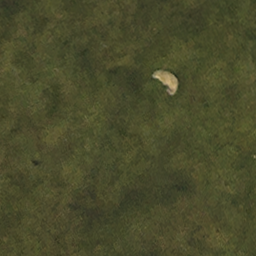

In [13]:
images[39]

False


([array([[[ 79,  78,  47, 255],
          [ 78,  77,  47, 255],
          [ 71,  69,  43, 255],
          ...,
          [ 70,  71,  43, 255],
          [ 70,  71,  43, 255],
          [ 69,  70,  41, 255]],
  
         [[ 82,  81,  51, 255],
          [ 69,  69,  42, 255],
          [ 70,  70,  43, 255],
          ...,
          [ 72,  74,  46, 255],
          [ 68,  71,  43, 255],
          [ 68,  69,  41, 255]],
  
         [[ 82,  81,  53, 255],
          [ 67,  65,  41, 255],
          [ 68,  69,  43, 255],
          ...,
          [ 75,  77,  47, 255],
          [ 75,  78,  46, 255],
          [ 73,  75,  43, 255]],
  
         ...,
  
         [[ 67,  71,  42, 255],
          [ 71,  74,  44, 255],
          [ 75,  77,  46, 255],
          ...,
          [ 73,  74,  43, 255],
          [ 62,  65,  33, 255],
          [ 63,  67,  35, 255]],
  
         [[ 69,  73,  44, 255],
          [ 74,  78,  48, 255],
          [ 76,  79,  48, 255],
          ...,
          [ 75,  77,  44, 25

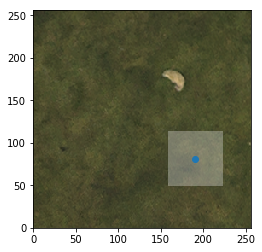

In [13]:
extract_random_patches(images[39], image_filepaths[39], 1, plot=True)

In [55]:
storage_patches = np.empty((0, 2*dx, 2*dy, 4))
storage_boxes = np.empty((0,4))
storage_bool = np.empty((0))
storage_fp = np.empty((0))

for img, fp in zip(images, image_filepaths):
    # extract random patches from image:
    patches, boxes, patches_bool, patches_fp = extract_random_patches(img, fp, 1)
    # store random patches
    storage_patches = np.append(storage_patches, np.array(patches), axis=0)
    storage_boxes = np.append(storage_boxes, np.array(boxes), axis=0)
    storage_bool = np.append(storage_bool, np.array(patches_bool), axis=0)
    storage_fp = np.append(storage_fp, np.array(patches_fp), axis=0)
    
    # extract seal patch from image
    seals = df[df.fp==fp]  # grab all the seal coordinates of the tile
    for i, seal in seals.iterrows():
        try:
            patch, patch_box = extract_patch(img, seal.x%256, seal.y%256, dx, dy)

            storage_patches = np.append(storage_patches, np.array(patch), axis=0)
            storage_boxes = np.append(storage_boxes, np.array(patch_box), axis=0)
            storage_bool = np.append(storage_bool, np.array([True]), axis=0)
            storage_fp = np.append(storage_fp, np.array([fp]), axis=0)
        except ValueError:
            pass

In [56]:
storage_patches.shape

(2519, 64, 64, 4)

# greyscale and Hog

In [57]:
hogs = []
for patch in storage_patches:
    greyscale = savewally.RGB2Lum(patch)
    hog_vec = feature.hog(greyscale, visualize=False)
    hogs.append(hog_vec)

C:\Users\r02as18\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [58]:
len(hogs)

2519

In [59]:
X = np.array(hogs)
y = np.array(storage_bool)[:,np.newaxis]

In [60]:
X.shape

(2519, 2916)

In [61]:
y.shape

(2519, 1)

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size=0.5, random_state=42)

In [63]:
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train, y_train.ravel())

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [64]:
score = clf.score(X_val, y_val)

In [65]:
score

0.7698412698412699

In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_val, clf.predict(X_val), digits=3))

              precision    recall  f1-score   support

         0.0      0.773     0.992     0.869       387
         1.0      0.571     0.034     0.065       117

   micro avg      0.770     0.770     0.770       504
   macro avg      0.672     0.513     0.467       504
weighted avg      0.726     0.770     0.682       504

